# Gene essentiality

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')
from pandas import DataFrame
from cobra.io import read_sbml_model
%matplotlib inline
model = read_sbml_model('data/e_coli_core.xml.gz')

## Knocking out a single gene

In the model, exactly one gene is associated with reaction with [phosphoglycerate kinase](http://bigg.ucsd.edu/universal/reactions/PGK) (PGK).

In [2]:
model.reactions.PGK.genes

frozenset({<Gene b2926 at 0x11ac145c0>})

Checking the name of this gene in the model (the id is the Blattner number b2926), reveals that it is indeed [pgk](http://ecocyc.org/gene?orgid=ECOLI&id=EG10703).

In [3]:
model.genes.b2926.name

'pgk'

Is [pgk](http://ecocyc.org/gene?orgid=ECOLI&id=EG10703) essential? Let's find out.

In [4]:
with model as pgk_mutant:
    pgk_mutant.genes.b2926.knock_out()
    print(pgk_mutant.slim_optimize())

0.0


Yes, it is.

## Perform all possible single gene deletions

Using a `for` loop allows to iterate over all genes in the model and knock out each one of them individually. We're using the model as a context to undo every gene deletion before proceeding to the next knockout.

In [5]:
essentiality = {}
for gene in model.genes:
    with model:
        gene.knock_out()
        essentiality[gene] = model.slim_optimize(error_value=0.)

In [6]:
essentiality

{<Gene b0351 at 0x11abe88d0>: 0.8739215069684303,
 <Gene b1241 at 0x11abe8978>: 0.8739215069684303,
 <Gene s0001 at 0x11abe8ba8>: 0.21114065257211811,
 <Gene b1849 at 0x11abe8dd8>: 0.8739215069684366,
 <Gene b3115 at 0x11abe8e80>: 0.8739215069684366,
 <Gene b2296 at 0x11abed0f0>: 0.8739215069684366,
 <Gene b1276 at 0x11abed320>: 0.8739215069684366,
 <Gene b0118 at 0x11abed550>: 0.8739215069684366,
 <Gene b0474 at 0x11abed780>: 0.8739215069684366,
 <Gene b0116 at 0x11abed9b0>: 0.7823510529477373,
 <Gene b0726 at 0x11abedbe0>: 0.8583074080226895,
 <Gene b0727 at 0x11abede10>: 0.8583074080226895,
 <Gene b2587 at 0x11abef080>: 0.8739215069684314,
 <Gene b0356 at 0x11abef2b0>: 0.8739215069684314,
 <Gene b1478 at 0x11abef4e0>: 0.8739215069684314,
 <Gene b3731 at 0x11abef710>: 0.3742298749331111,
 <Gene b3733 at 0x11abef940>: 0.3742298749331111,
 <Gene b3735 at 0x11abefb70>: 0.3742298749331111,
 <Gene b3739 at 0x11abefda0>: 0.8739215069684335,
 <Gene b3732 at 0x11abeffd0>: 0.3742298749331108,

In [8]:
df = DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')

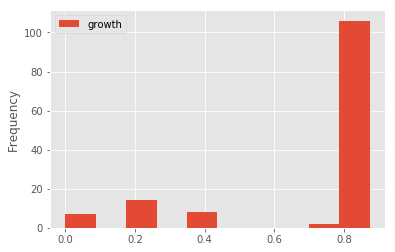

In [9]:
df.plot.hist()

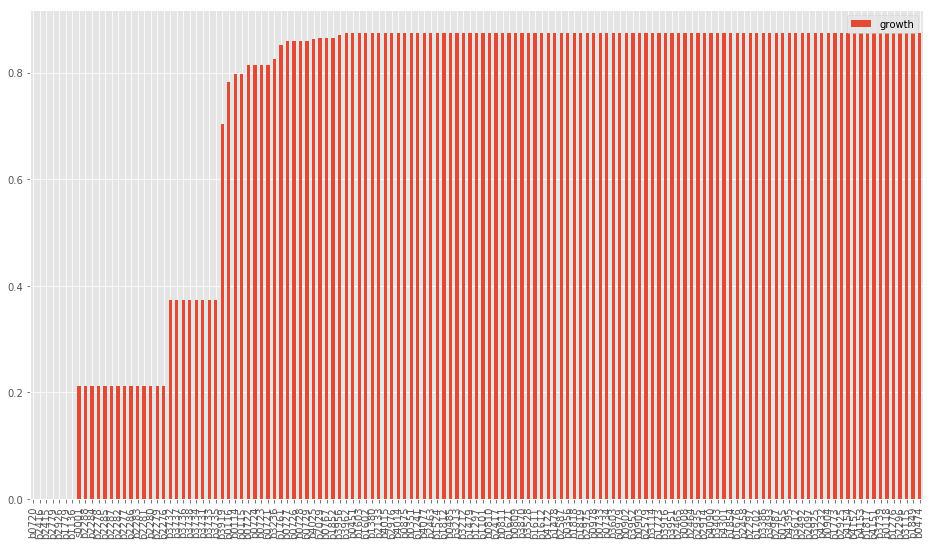

In [10]:
ax = df.plot.bar().axes
ax.figure.set_size_inches(16, 9)

## Exercises

1. How many genes are in each category (essential and non-essential)? How many non-essential genes show a reduced growth rate?
2. Determine the essentialiy of genes for all other available carbon sources (if this is too complicated, determine the essentiality profile for one other carbon source).

Hints:
* Sometimes an optimal solution cannot be found for certain knockouts (an exception is raised). Use `try` and `except` to catch infeasible solutions.

In [11]:
carbon_exchanges = ['EX_ac_e', 'EX_etoh_e', 'EX_for_e',
                    'EX_fru_e', 'EX_fum_e', 'EX_glc__D_e',
                    'EX_lac__D_e', 'EX_mal__L_e', 'EX_pyr_e', 'EX_succ_e']

## Gene essentiality with respect to each biomass precursor

In [12]:
biomass_precursors = model.reactions.BIOMASS_Ecoli_core_w_GAM.reactants
len(biomass_precursors)

16

In [13]:
biomass_precursors

[<Metabolite 3pg_c at 0x11ab95e48>,
 <Metabolite accoa_c at 0x11abb14e0>,
 <Metabolite atp_c at 0x11abb6828>,
 <Metabolite e4p_c at 0x11abbd048>,
 <Metabolite f6p_c at 0x11abbda90>,
 <Metabolite g3p_c at 0x11abc3d30>,
 <Metabolite g6p_c at 0x11abc8048>,
 <Metabolite gln__L_c at 0x11abc8438>,
 <Metabolite glu__L_c at 0x11abc8780>,
 <Metabolite h2o_c at 0x11abc2278>,
 <Metabolite nad_c at 0x11abd6630>,
 <Metabolite nadph_c at 0x11abd6f28>,
 <Metabolite oaa_c at 0x11abdbf28>,
 <Metabolite pep_c at 0x11abdf278>,
 <Metabolite pyr_c at 0x11abdfc18>,
 <Metabolite r5p_c at 0x11abe15f8>]

In [14]:
precursor_production = pd.DataFrame(columns=['knocked_gene', 'precursor', 'max_production'])
index = 0
for precursor in biomass_precursors:
    print('Determining essentiality profile for precursor: ' + precursor.id)
    with model:
        model.objective = model.add_boundary(precursor, type='demand')
        for gene in model.genes:
            with model:
                gene.knock_out()
                precursor_production.loc[index] = gene.name, precursor.id, model.slim_optimize(error_value=0.)
                index += 1

Determining essentiality profile for precursor: 3pg_c
Determining essentiality profile for precursor: accoa_c
Determining essentiality profile for precursor: atp_c
Determining essentiality profile for precursor: e4p_c
Determining essentiality profile for precursor: f6p_c
Determining essentiality profile for precursor: g3p_c
Determining essentiality profile for precursor: g6p_c
Determining essentiality profile for precursor: gln__L_c
Determining essentiality profile for precursor: glu__L_c
Determining essentiality profile for precursor: h2o_c
Determining essentiality profile for precursor: nad_c
Determining essentiality profile for precursor: nadph_c
Determining essentiality profile for precursor: oaa_c
Determining essentiality profile for precursor: pep_c
Determining essentiality profile for precursor: pyr_c
Determining essentiality profile for precursor: r5p_c


In [15]:
precursor_production['can_produce'] = precursor_production['max_production'].apply(lambda x: 0 if x < 0.05 else 1)

In [16]:
precursor_production

,knocked_gene,precursor,max_production,can_produce
0,mhpF,3pg_c,19.6233,1
1,adhE,3pg_c,19.6233,1
2,s0001,3pg_c,8.4933,1
3,purT,3pg_c,19.6233,1
4,tdcD,3pg_c,19.6233,1
...,...,...,...,...
2187,talB,r5p_c,10.0920,1
2188,talA,r5p_c,10.0920,1
2189,tktA,r5p_c,10.0920,1
2190,tktB,r5p_c,10.0920,1


In [17]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

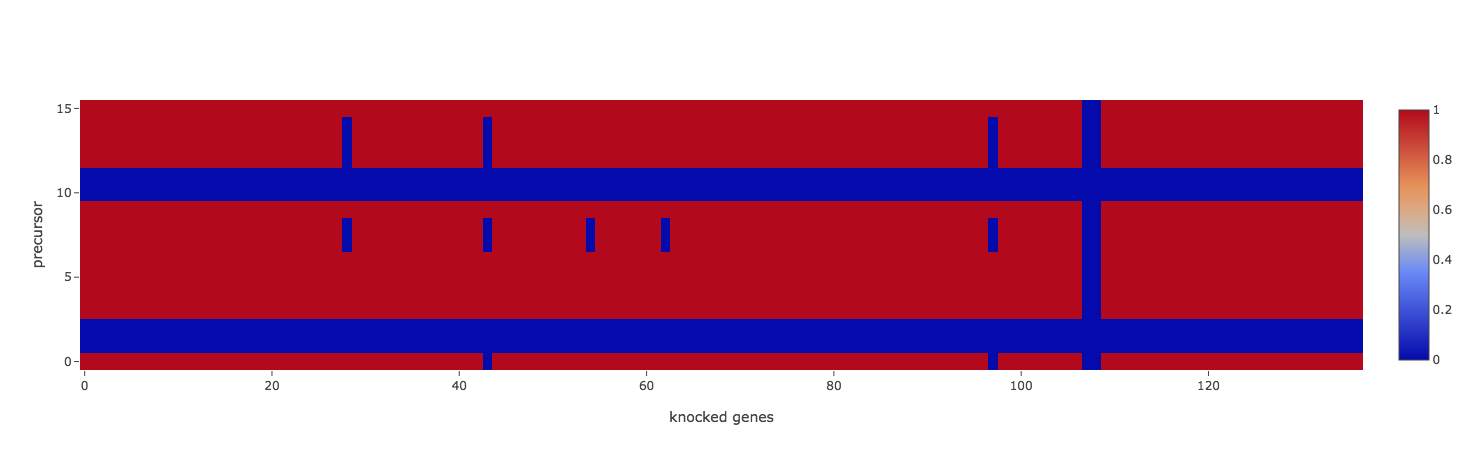

In [18]:
df = precursor_production.pivot(index='precursor', columns='knocked_gene', values='can_produce')
data = [go.Heatmap(z=df.values.tolist())]
layout = go.Layout(xaxis=dict(title='knocked genes'), yaxis=dict(title='precursor'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)